In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np

In [29]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
# mpl.rcParams['text.usetex'] = True # comment out this line if the machine does not have TeX installed
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [30]:
num_seeds = 10
out_path = "../output"
DATASET = "imagenet_captions"
N_TASKS = 5

model_names = {
    'RN50': 'ResNet50', 
    'nllb-clip-base': 'NLLB-CLIP', 
    'ViT-B-32': 'ViT-B/32'
}

color1 = "indigo"
color5 = "darkgoldenrod"

In [31]:
def load_result_uniform(dataset, model, task_id, sample_size, seed):
    templates = f"{dataset}/task_{task_id:02d}_sample_size_{sample_size}_seed_{seed:02d}"
    with open(os.path.join(out_path, f"{model}/{templates}.json"), 'r') as f:
        result = json.load(f)
    return result

def load_result_nonuniform(dataset, model, task_id, sample_size, seed):
    templates = f"{dataset}/task_{task_id:02d}_sample_size_{sample_size}_seed_{seed:02d}_variance"
    with open(os.path.join(out_path, f"{model}/{templates}.json"), 'r') as f:
        result = json.load(f)
    return result

def load_baseline(model, task_id):
    pretrained = {
        'RN50':'yfcc15m',
        'nllb-clip-base': 'v1',
        'ViT-B-32': 'datacomp_m_s128m_b4k',
    }[model]
    out_fp = os.path.join(out_path, f"{model}/{pretrained}/imagenet1k_{N_TASKS}_tasks_{task_id}.json")
    with open(out_fp, 'r') as file:
        result = json.load(file)
    return result

In [32]:
sample_sizes = [50, 100]
metrics = ['Accuracy (Top-1)', 'Average Precision', 'Average Recall']

model_names = {
    'RN50': 'ResNet50', 
    'nllb-clip-base': 'NLLB-CLIP', 
    'ViT-B-32': 'ViT-B/32'
}

def create_ax(ax, model, task_id, n_seeds=10):
    seeds = np.arange(n_seeds)
    data = {}
    for m in sample_sizes:
        acc, pre, rec = [], [], []
        for seed in seeds:
            result = load_result_nonuniform(DATASET, model, task_id, m, seed)
            base = load_result_uniform(DATASET, model, task_id, m, seed)
            acc.append(result["acc1"] - base["acc1"])
            pre.append(result["classification_report"]["macro avg"]["precision"] - base["classification_report"]["macro avg"]["precision"])
            rec.append(result["classification_report"]["macro avg"]["recall"] - base["classification_report"]["macro avg"]["recall"])
        acc, pre, rec = np.array(acc), np.array(pre), np.array(rec)
        data[m] = [acc.mean(), pre.mean(), rec.mean()]

    # Plot setup
    x = np.array([0.25, 0.75])  # [0, 1] for two groups
    width = 0.1 # width of each bar
    offsets = [-width, 0, width]  # positions for each metric

    # Plot each metric
    for i, metric in enumerate(metrics):
        values = [data[m][i] for m in sample_sizes]
        ax.bar(x + offsets[i], values, width, label= r"$\Delta$" + metric, edgecolor="k")

    # Labeling
    ax.set_xticks(x)
    ax.set_xticklabels([r"$M = $" + f"{m}" for m in sample_sizes])
    ax.set_xlim((0, 1))
    # ax.set_ylim((-0.01, 0.01))
    ax.set_ylim((-0.1, 0.1))
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1.5)  


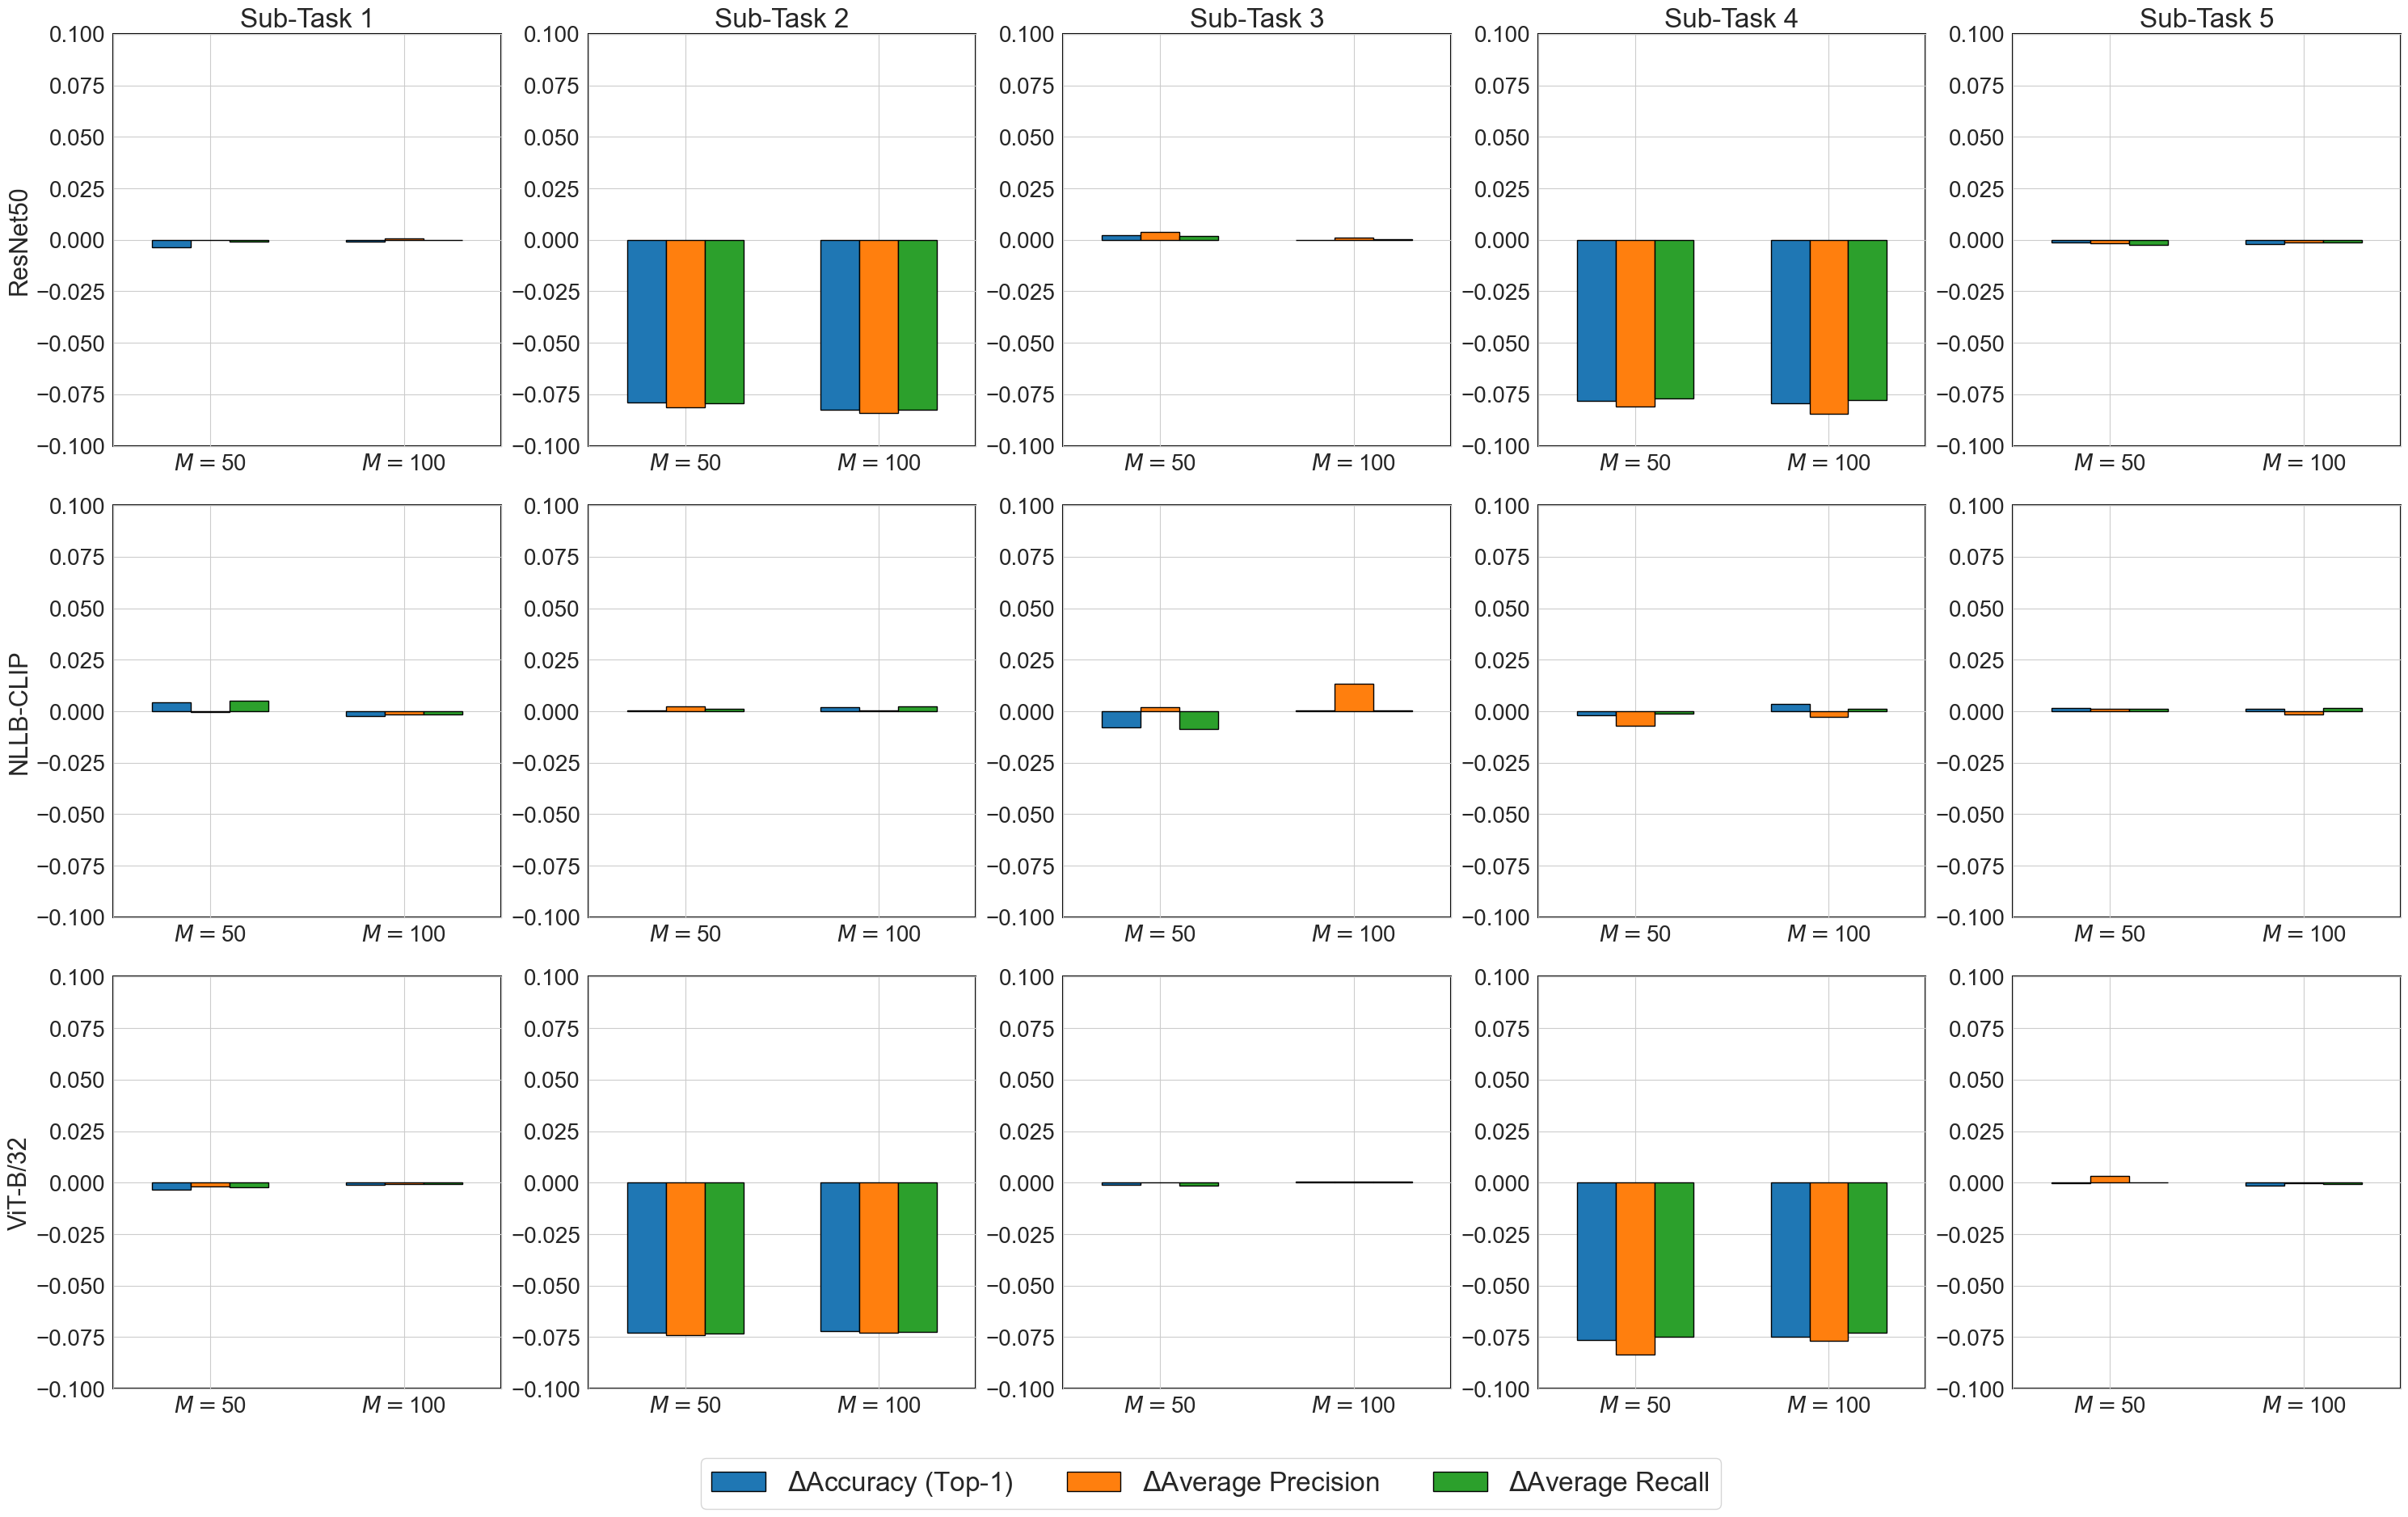

In [33]:
sns.set_style("whitegrid")
scale = 6
tasks = np.arange(5)
# tasks = [0, 2, 4]
fig, axes = plt.subplots(3, len(tasks), figsize=(len(tasks) * scale, 3 * scale))
n_seeds = 10

for i, model in enumerate(model_names):
    axes[i, 0].set_ylabel(model_names[model])
    for j, task_id in enumerate(tasks):
        if i == 0:
            axes[i, j].set_title(f'Sub-Task {task_id + 1}')
        create_ax(axes[i, j], model, task_id, n_seeds=n_seeds)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=3)

fig.tight_layout(pad=2.0)
plt.show()